In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
readings = np.load("/home/sadeep/fyp_ws/src/button_localization/localization/points.npy")

In [3]:
mean_readings = np.mean(readings, axis=0)
mean_readings.shape

(76, 2)

In [4]:
r = mean_readings[:, 0]
theta = mean_readings[:, 1]
theta = np.deg2rad(theta)   # convert to radians

In [5]:
mask = r < 1 
r = r[mask]
theta = theta[mask]

r.shape

(76,)

In [6]:
sin_theta = np.sin(theta)
cos_theta = np.cos(theta)

dx = 0   # x offset from base frame
dy = 0.23   # y offset from base frame
x = r * sin_theta + dx
y = r * cos_theta + dy


finding alpha and delta for x and z array

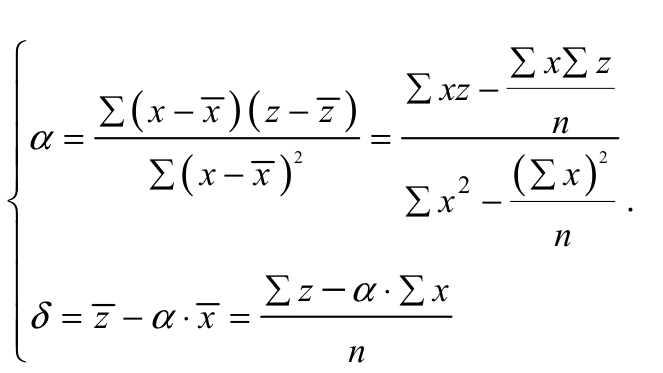

In [7]:
x_mean = np.mean(x)
y_mean = np.mean(y)

x_shift = x - x_mean
y_shift = y - y_mean

alpha = np.sum(x_shift * y_shift) / np.sum(x_shift**2)
delta = y_mean - alpha * x_mean

In [8]:
alpha, delta

(0.004132822656847993, 0.5889624884063697)

In [9]:
y_line = alpha * x + delta

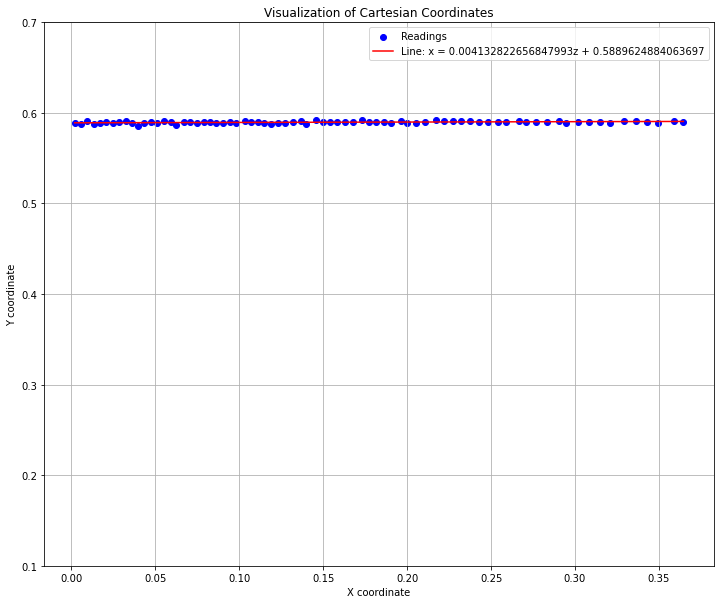

In [10]:
plt.figure(figsize=(12, 10))

# Scatter plot
plt.scatter(x, y, c='b', marker='o', label='Readings')

# Optionally, you can also use a line plot
plt.plot(x, y_line, linestyle='-', color='r', label=f'Line: x = {alpha}z + {delta}')

plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title('Visualization of Cartesian Coordinates')
# Set the range for the z-axis
plt.ylim(0.1, 0.7)
plt.legend()
plt.grid(True)
plt.show()


In [23]:
image_width = 1280
image_height = 720
horizontal_fov = 1.7633 # radians


####################### Intrinsic Parameters #######################

# Focal length
f_x = 537.6983672158217
f_y = 537.1784833375057

# Principal point
c_x = 640.9944295362419  
c_y = 362.64041228998025 

####################################################################

# Intrinsic matrix
K = np.array([
    [f_x, 0  , c_x],
    [0  , f_y, c_y],
    [0  , 0  , 1  ] 
])

# K_inv = np.linalg.inv(K)


In [29]:
point_cam = np.array([0.1, 0.5, 0.2])   # point is in the camera optical frame
ans_ = K @ point_cam
ans_[0] /= ans_[2]
ans_[1] /= ans_[2]
ans_[2] /= ans_[2]

pixels_u = ans_[0]
pixels_v = ans_[1]

print(pixels_u, pixels_v)

909.8436131441528 1705.5866206337444


In [30]:
# Pixel coordinates (u, v) and depth Z (in meters)
u = 909.8436131441528  # example pixel x-coordinate
v = 1705.5866206337444 # example pixel y-coordinate
Z = 0.2                # example depth value in meters

# Compute the 3D coordinates
X = Z * (u - c_x) / f_x
Y = Z * (v - c_y) / f_y

point_3D = np.array([X, Y, Z])
point_3D

array([0.1, 0.5, 0.2])

In [99]:
R = np.array([
    [1.000, 0.000, 0.001],
    [-0.001, 0.000, 1.000],
    [0.000, -1.000, 0.000],
])

t = np.array([- 0.060, 0.060, 1.100 ])

n = np.array([alpha, 0, -1])

u = (946 )
v = (388 )
p = np.array([u, v, 1])

In [100]:

def calculate_scaling_factor(n, R, t, K, p):
    """
    Calculates the scaling factor for the 3D point.

    Args:
        n: Plane normal vector.
        R: Rotation matrix.
        t: Translation vector.
        K: Intrinsic matrix.
        p: 2D camera coordinates.

    Returns:
        Scaling factor.
    """

    w = (n.dot(np.linalg.inv(R).dot(t)) -  delta) / (n.dot(np.linalg.inv(R).dot(np.linalg.inv(K)).dot(p)))
    return w

In [101]:
w = calculate_scaling_factor(n, R, t, K, p)
w

13.287313536198022

In [102]:
def calculate_3d_point(w, R, t, K, p):
    """
    Calculates the 3D point in world coordinates.

    Args:
        w: Scaling factor.
        R: Rotation matrix.
        t: Translation vector.
        K: Intrinsic matrix.
        p: 2D camera coordinates.

    Returns:
        P: 3D point in world coordinates.
    """

    P = w * (np.linalg.inv(R).dot(np.linalg.inv(K)).dot(p) - np.linalg.inv(R).dot(t))
    return P

In [103]:
P = calculate_3d_point(w, R, t, K, p)
P

array([ 8.33453444,  1.32873135, -0.16162526])

In [5]:
# cos inverse
a = 2.017 / 2.0116
b = np.arctan(a)
b = np.rad2deg(b)
b

45.076800135052196

In [2]:
transform_mat = np.array([
    [1.000, 0.000, 0.000, 0.230],
    [0.000, 1.000, 0.000, 0.000],
    [0.000, 0.000, 1.000, 0.001],
    [0.000, 0.000, 0.000, 1.000]
])

m = -0.0024
normal = np.array([-1, m, 0, 1])

transformed_normal = np.dot(transform_mat, normal)
transformed_normal, normal

(array([-0.77  , -0.0024,  0.001 ,  1.    ]),
 array([-1.    , -0.0024,  0.    ,  1.    ]))